## PJM On-Peak Basis Forecast Model

In this project, we aim to construct a Machine Learning model that forecasts the PJM Day-Ahead on-peak basis. After 5 PM on any given day, suppose we have the following information:
- The RT basis before 5 PM
- The whole day DA basis for tomorrow
- The load forecast for the day after tomorrow. 

With this input data, we will train a model that predicts the on-peak basis for the day after tomorrow. Currently, the goal is to setup a baseline model that can be improved down the road.

## Data Exploration and Preprocessing

The input dataset is extremely large and convoluted. Before we begin training the model, we need to experiment with some approaches to aggregate the input data and reduce the dimensionality of the feature space. Here are some ideas:
- Reduce the input hourly data by averaging together offpeak (0-7) and on-peak hours (8-23) separately 
- Only consider columns AQ-AS of the raw data, which correspond to Southern, Western, and RTO Combined averages.
- Shift the data so that the inputs align correctly with their predicted values.

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.simplefilter("ignore")

input_path = "./Input Data/"
file_path = os.path.join(input_path, "basis_forecast.xlsx")

data = pd.read_excel(file_path, skiprows=1)
da_basis = data.iloc[:, :9]  # Columns A:I
rt_basis = data.iloc[:, 10:20]  # Columns K:T
load_forecast = data.iloc[:, [21, 42, 43, 44]]  # Columns V, AP, AQ, AR

rt_basis.rename(columns={"Date/Time.1": "Date/Time"}, inplace=True)
load_forecast.rename(columns={"Date/Time.2": "Date/Time"}, inplace=True)


In [215]:
def extract_date_hour(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts date and hour information from the first column of a DataFrame containing
    datetime values in the format '%m/%d/%Y %H:%M' and adds them as new columns at the
    beginning of the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame with a datetime column.

    Returns:
        pd.DataFrame: A modified DataFrame with 'Date' and 'Hour' columns inserted at
        the beginning, derived from the datetime values in the first column.
    """
    first_column = df["Date/Time"]

    df.insert(0, "Hour", pd.to_datetime(first_column, format='%m/%d/%Y %H:%M').dt.hour) 
    df.insert(0, "Date", pd.to_datetime(first_column, format='%m/%d/%Y %H:%M').dt.date) 

    df = df.drop(columns=["Date/Time"])
    return df

def onpeak_averages(df: pd.DataFrame, max_hour=23) -> pd.DataFrame:
    result_df = df[df['Hour'].between(8, max_hour)].groupby('Date').mean()
    result_df.reset_index(inplace=True)

    return result_df

In [216]:
da_basis = extract_date_hour(da_basis)
rt_basis = extract_date_hour(rt_basis)
load_forecast = extract_date_hour(load_forecast)

da_basis_avg = onpeak_averages(da_basis)
rt_basis_avg_5 = onpeak_averages(rt_basis, 17)
load_forecast_avg = onpeak_averages(load_forecast)

In [217]:
filtered_da_basis = da_basis_avg.drop(columns=["Hour", "WESTERN HUB (DALMP) Average"])
filtered_rt_basis = rt_basis_avg_5.drop(columns=["Hour", "WESTERN HUB (RTLMP) Average", "DOM (RTLMP) Average"])
filtered_load = load_forecast_avg.drop(columns=["Hour"])

y_pred = filtered_da_basis.iloc[:, [0, 2]]
y_pred

,Date,STEEL CITY 4CC (DALMP ) - WESTERN HUB (DALMP )
0,2023-03-02,-5.481743
1,2023-03-03,-4.164907
2,2023-03-04,-5.338982
3,2023-03-05,-3.925585
4,2023-03-06,-7.633045
...,...,...
179,2023-08-28,-15.680761
180,2023-08-29,-18.844916
181,2023-08-30,-8.989348
182,2023-08-31,-7.295863


In [218]:
"""
Begin the process of merging together the dataframes to one large matrix. if we want to predict day x, align the matrices so that the columns correspond to
    - The y-variable (actual DA basis) for day x
    - The seven columns of RT basis (onpeak averages before 5 PM) corresponding to day x-2
    - The three columns of Load Forecast for day x
    - The seven columns of whole day DA basis (onpeak averages) for day x-1
"""
aligned_rt_basis = filtered_rt_basis.copy()
aligned_rt_basis['Date'] = aligned_rt_basis['Date'] - pd.DateOffset(days=2)

aligned_da_basis = filtered_da_basis.copy()
aligned_da_basis['Date'] = aligned_da_basis['Date'] - pd.DateOffset(days=1)

aligned_da_basis['Date'] = pd.to_datetime(aligned_da_basis['Date'])
aligned_rt_basis['Date'] = pd.to_datetime(aligned_rt_basis['Date'])
y_pred['Date'] = pd.to_datetime(y_pred['Date'])
filtered_load['Date'] = pd.to_datetime(filtered_load['Date'])

merged_df = pd.merge(aligned_da_basis, aligned_rt_basis, on='Date', how='inner')
merged_df = pd.merge(merged_df, y_pred, on='Date', how='inner')
merged_df = pd.merge(merged_df, filtered_load, on='Date', how='inner')

## Abbreviate the column names
new_column_names = {
    'EDGEMOOR 13 KV HAYRD5 (DALMP ) - WESTERN HUB (DALMP )': "EDGE_DA",
    'STEEL CITY 4CC (DALMP ) - WESTERN HUB (DALMP )_x': "STC_DA_x",
    "PPL (DALMP ) - PECO (DALMP )": "PPL_PECO_DA",
    'PEACHBOT 22 KV UNIT02 (DALMP ) - WESTERN HUB (DALMP )': "PEACH_DA",
    'DPL (DALMP ) - WESTERN HUB (DALMP )': "DPL_DA",
    'PPL (DALMP ) - WESTERN HUB (DALMP )': "PPL_DA",
    'PECO (DALMP ) - WESTERN HUB (DALMP )': "PECO_DA",
    'EDGEMOOR 13 KV HAYRD5 (RTLMP ) - WESTERN HUB (RTLMP )': "EDGE_RT",
    'STEEL CITY 4CC (RTLMP ) - WESTERN HUB (RTLMP )': "STC_RT",
    'PEACHBOT 22 KV UNIT02 (RTLMP ) - WESTERN HUB (RTLMP )': "PEACH_RT",
    'DPL (RTLMP ) - WESTERN HUB (RTLMP )': "DPL_RT",
    'PPL (RTLMP ) - WESTERN HUB (RTLMP )': "PPL_RT",
    'PECO (RTLMP ) - WESTERN HUB (RTLMP )': "PECO_RT",
    'DOM (RTLMP ) - WESTERN HUB (RTLMP )': "DOM_RT",
    'STEEL CITY 4CC (DALMP ) - WESTERN HUB (DALMP )_y': "STC_DA_y",
    'SOUTHERN REGION (BIDCLOSE_LOAD_FORECAST) Average': "SOUTH_L",
    'WESTERN REGION (BIDCLOSE_LOAD_FORECAST) Average': "WEST_L",
    'RTO COMBINED (BIDCLOSE_LOAD_FORECAST) Average': "RTO_L"
}
merged_df.rename(columns=new_column_names, inplace=True)
merged_df

,Date,EDGE_DA,STC_DA_x,PEACH_DA,DPL_DA,PPL_DA,PECO_DA,PPL_PECO_DA,EDGE_RT,STC_RT,PEACH_RT,DPL_RT,PPL_RT,PECO_RT,DOM_RT,STC_DA_y,SOUTH_L,WEST_L,RTO_L
0,2023-03-02,-5.699907,-4.164907,-5.024282,-5.370517,-2.665954,-5.550337,2.884383,-4.455089,-3.256089,-3.920089,-4.464301,-2.551873,-4.276279,0.593465,-5.481743,12160.8750,46643.5625,88391.7500
1,2023-03-03,-6.891482,-5.338982,-5.978357,-6.159625,-4.013960,-6.782493,2.768533,-4.163170,-3.201170,-3.648170,-4.155714,-2.661704,-4.133757,0.656563,-4.164907,13030.6875,47585.5000,92872.9375
2,2023-03-04,-5.150585,-3.925585,-4.559335,-4.720920,-3.195029,-5.111387,1.916358,-18.010050,-12.555050,-16.864050,-18.842054,-8.956149,-17.522332,1.528732,-5.338982,11616.0000,43177.9375,83955.9375
3,2023-03-05,-10.824295,-7.633045,-10.318670,-10.586316,-5.572445,-10.567663,4.995217,-5.390208,-3.506208,-5.138208,-5.162551,-2.375615,-4.974634,0.619508,-3.925585,11899.8125,42125.0625,82131.6875
4,2023-03-06,-11.238461,-7.679086,-10.512836,-10.168993,-5.271303,-10.836789,5.565486,-6.675416,-4.325416,-6.360416,-6.641052,-3.001893,-6.259838,0.833252,-7.633045,12661.8125,46351.1250,89498.1250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2023-08-26,-13.562325,-13.369825,-13.556700,-9.020820,-14.854803,-12.852762,-2.002041,-5.447907,-4.593907,-5.119907,-4.628343,-3.850061,-5.063865,1.223099,-13.867030,17103.1250,52784.0625,107063.8125
178,2023-08-27,-16.828261,-15.680761,-16.435136,-15.948193,-16.357958,-16.524892,0.166935,-1.826841,-1.842841,-1.862841,-0.809598,-1.712448,-1.430398,0.477316,-13.369825,15410.6875,46721.5625,96365.0000
179,2023-08-28,-12.468041,-18.844916,-12.204291,-9.414580,-12.397914,-11.955101,-0.442812,-2.315178,-1.898178,-2.025178,-1.567272,-1.276480,-2.065026,1.079419,-15.680761,15111.6250,52011.9375,102796.1875
180,2023-08-29,-8.507473,-8.989348,-8.597473,-0.234348,-7.481840,-7.672713,0.190873,-10.668726,-7.622726,-9.474726,-11.235153,-5.584388,-10.721545,1.593029,-18.844916,16250.8125,52445.1250,105658.6250


### Create training, testing split and visualize the input data.

In [219]:
from sklearn.model_selection import train_test_split

merged_df = merged_df.drop(["Date"], axis=1)

X = merged_df.drop(["STC_DA_y"], axis=1)
y = merged_df["STC_DA_y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
train_data = X_train.join(y_train)

train_data

,EDGE_DA,STC_DA_x,PEACH_DA,DPL_DA,PPL_DA,PECO_DA,PPL_PECO_DA,EDGE_RT,STC_RT,PEACH_RT,DPL_RT,PPL_RT,PECO_RT,DOM_RT,SOUTH_L,WEST_L,RTO_L,STC_DA_y
117,-13.434650,-11.713400,-12.778400,-13.018915,-10.834130,-13.085206,2.251076,-2.581661,-3.247661,-2.700661,-1.635072,-4.580317,-2.176989,0.718101,15597.3750,49833.2500,101250.8750,-9.178896
38,-9.342288,-8.284163,-8.797913,-8.711451,-7.686425,-9.316349,1.629924,-2.131123,-1.573123,-1.921123,-1.642961,-1.060847,-1.760696,1.479213,11175.5625,36373.8125,72114.1250,-3.549465
118,-16.977534,-14.844409,-17.883159,-15.782518,-14.281559,-15.572280,1.290721,-1.759155,-1.966155,-1.756155,-0.544273,-2.264407,-1.238535,0.425552,15436.4375,52452.8750,103115.9375,-11.713400
150,-13.894082,-12.947832,-13.275332,-10.204595,-11.715889,-13.362364,1.646476,-6.738349,-5.555349,-6.032349,-6.604240,-4.990300,-6.583145,1.158008,16816.6250,50585.0625,103814.7500,-13.778399
75,-12.451715,-8.806715,-10.442340,-13.212946,-6.250555,-12.489824,6.239269,-5.353063,-3.484063,-4.207063,-5.305118,-2.631785,-4.264317,-0.079573,13178.7500,44433.3125,87490.6250,-9.323753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-13.818440,-11.899690,-12.822815,-13.831213,-11.584487,-13.618791,2.034304,-17.816074,-13.241074,-17.141074,-18.513098,-10.082843,-17.354331,2.656836,14579.8750,45417.1875,90739.1875,-7.413317
14,-6.297615,-4.957615,-5.806365,-5.854383,-3.916151,-6.427256,2.511105,-0.439670,-0.252670,-0.387670,0.157541,-0.265741,-0.189779,0.810021,12737.7500,47901.3125,90996.0000,-3.264757
92,-20.994278,-15.612403,-18.038028,-21.877850,-12.565757,-21.461121,8.895364,-8.082913,-5.823913,-6.767913,-8.822162,-4.393190,-8.236533,1.401168,14565.1875,58901.8750,110903.6875,-16.676941
179,-12.468041,-18.844916,-12.204291,-9.414580,-12.397914,-11.955101,-0.442812,-2.315178,-1.898178,-2.025178,-1.567272,-1.276480,-2.065026,1.079419,15111.6250,52011.9375,102796.1875,-15.680761


array([[<AxesSubplot:title={'center':'EDGE_DA'}>,
        <AxesSubplot:title={'center':'STC_DA_x'}>,
        <AxesSubplot:title={'center':'PEACH_DA'}>,
        <AxesSubplot:title={'center':'DPL_DA'}>],
       [<AxesSubplot:title={'center':'PPL_DA'}>,
        <AxesSubplot:title={'center':'PECO_DA'}>,
        <AxesSubplot:title={'center':'PPL_PECO_DA'}>,
        <AxesSubplot:title={'center':'EDGE_RT'}>],
       [<AxesSubplot:title={'center':'STC_RT'}>,
        <AxesSubplot:title={'center':'PEACH_RT'}>,
        <AxesSubplot:title={'center':'DPL_RT'}>,
        <AxesSubplot:title={'center':'PPL_RT'}>],
       [<AxesSubplot:title={'center':'PECO_RT'}>,
        <AxesSubplot:title={'center':'DOM_RT'}>,
        <AxesSubplot:title={'center':'SOUTH_L'}>,
        <AxesSubplot:title={'center':'WEST_L'}>],
       [<AxesSubplot:title={'center':'RTO_L'}>,
        <AxesSubplot:title={'center':'STC_DA_y'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

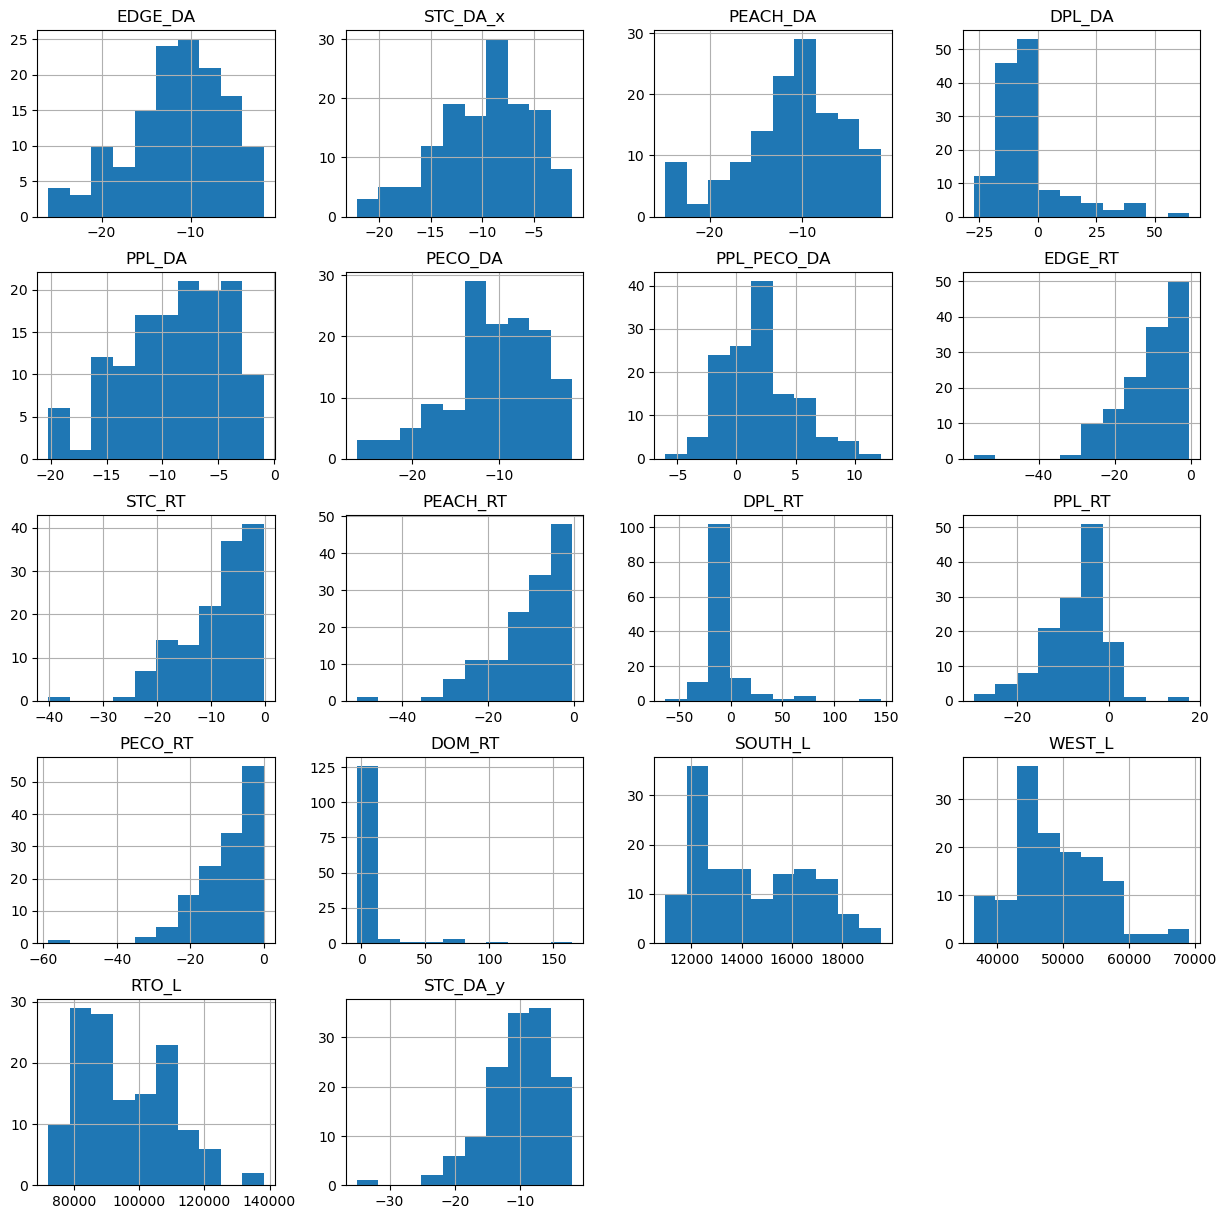

In [220]:
train_data.hist(figsize=(15, 15))

<AxesSubplot:>

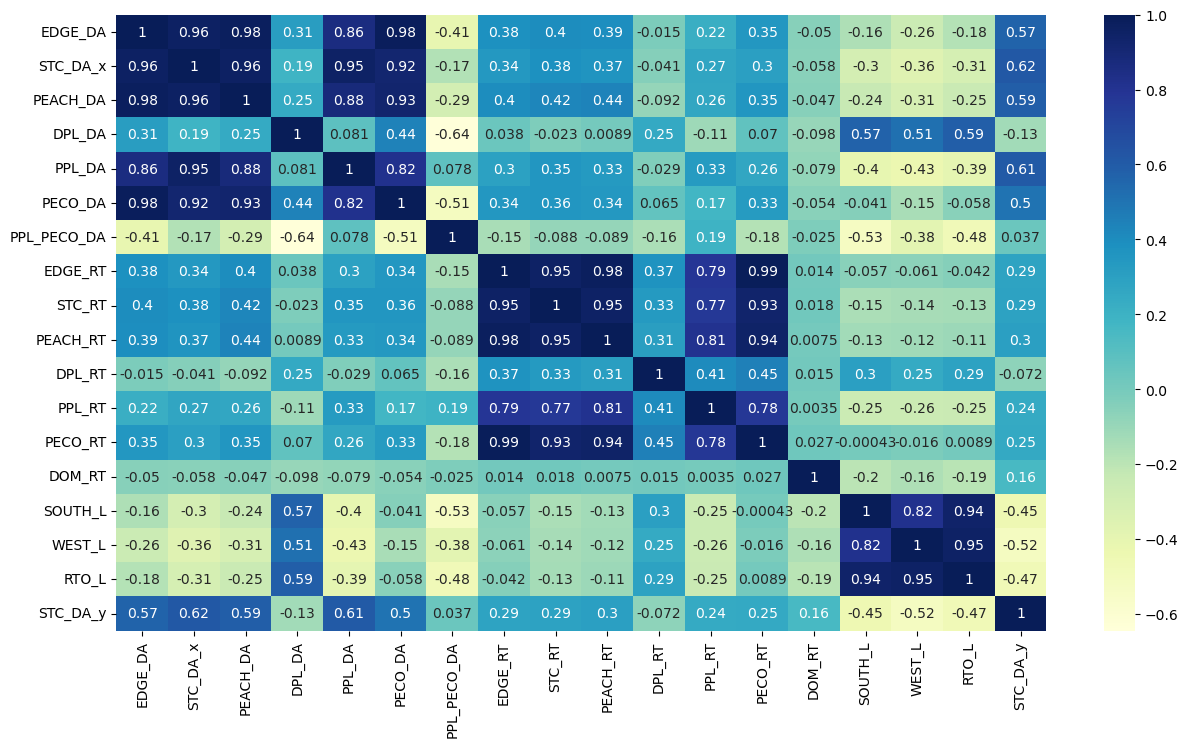

In [221]:
plt.figure(figsize=(15,8))
sns.heatmap(train_data.corr(), annot=True, cmap="YlGnBu")

## Model Building

- We start with a basic linear regression model
- Then, we move on to a machine learning random forest model

In [222]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train, y_train = train_data.drop(['STC_DA_y'], axis=1), train_data['STC_DA_y']
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

reg = LinearRegression()
reg.fit(X_train_s, y_train)

LinearRegression()

In [223]:
reg.score(X_test_s, y_test)

0.5336250790910628

In [224]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(X_train_s, y_train)

RandomForestRegressor()

In [225]:
forest.score(X_test_s, y_test)

0.6193130636550557

In [226]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [30, 50, 100],
    "max_features": [8, 12, 20],
    "min_samples_split": [2, 4, 6, 8]
}

grid_search = GridSearchCV(forest, param_grid, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(X_train_s, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_features': [8, 12, 20],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [30, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [227]:
best_forest = grid_search.best_estimator_

In [228]:
best_forest.score(X_test_s, y_test)

0.5950989729701194